# Refactored As Operational Pipeline (with MLRun)

In [ ]:
# Install prerequisites
%pip install mlrun lightgbm shapely

## Create an MLRun project and configuration

In [2]:
from os import path
import mlrun

project_name_base = 'nyc-taxi'

project = mlrun.get_or_create_project(project_name_base, user_project=True)

print(f'Project name: {project.name}')

> 2023-08-20 11:31:45,650 [info] Project loaded successfully: {'project_name': 'nyc-taxi'}
Project name: nyc-taxi-iguazio


## Define Nuclio and MLRun Functions

In [3]:
# mlrun: start-code

In [4]:
from os import path
import numpy as np 
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from pickle import dumps
import shapely.wkt

In [5]:
def get_zones_dict(zones_url):
    zones_df = pd.read_csv(zones_url)
    
    # Remove unecessary fields
    zones_df.drop(['Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'], axis=1, inplace=True)
    
    # Convert DF to dictionary
    zones_dict = zones_df.set_index('OBJECTID').to_dict('index')
    
    # Add lat/long to each zone
    for zone in zones_dict:
        shape = shapely.wkt.loads(zones_dict[zone]['the_geom'])
        zones_dict[zone]['long'] = shape.centroid.x
        zones_dict[zone]['lat'] = shape.centroid.y
    
    return zones_dict

In [6]:
def get_zone_lat(zones_dict, zone_id):
    return zones_dict[zone_id]['lat']

In [7]:
def get_zone_long(zones_dict, zone_id):
    return zones_dict[zone_id]['long']

In [8]:
def clean_df(df):
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
             (df.PULocationID > 0) & (df.PULocationID <= 263) & 
             (df.DOLocationID > 0) & (df.DOLocationID <= 263)]

In [9]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [10]:
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree)

In [11]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

In [12]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['tpep_pickup_datetime'],format="%Y-%m-%d %H:%M:%S")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [13]:
def fetch_data(context : MLClientCtx, taxi_records_csv_path: DataItem, zones_csv_path: DataItem):
    
    context.logger.info('Reading taxi records data from {}'.format(taxi_records_csv_path))
    taxi_records_dataset = taxi_records_csv_path.as_df()
    
    context.logger.info('Reading zones data from {}'.format(zones_csv_path))
    zones_dataset = zones_csv_path.as_df()
    
    target_path = path.join(context.artifact_path, 'data')
    context.logger.info('Saving datasets to {} ...'.format(target_path))

    # Store the data sets in your artifacts database
    context.log_dataset('nyc-taxi-dataset', df=taxi_records_dataset, format='csv',
                        index=False, artifact_path=target_path)
    context.log_dataset('zones-dataset', df=zones_dataset, format='csv',
                        index=False, artifact_path=target_path)    

In [14]:
def get_zones_dict(zones_df):

    # Remove unecessary fields
    zones_df.drop(['Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'], axis=1, inplace=True)
    
    # Convert DF to dictionary
    zones_dict = zones_df.set_index('OBJECTID').to_dict('index')
    
    # Add lat/long to each zone
    for zone in zones_dict:
        shape = shapely.wkt.loads(zones_dict[zone]['the_geom'])
        zones_dict[zone]['long'] = shape.centroid.x
        zones_dict[zone]['lat'] = shape.centroid.y
    
    return zones_dict

In [15]:
def get_zone_lat(zones_dict, zone_id):
    return zones_dict[zone_id]['lat']

In [16]:
def get_zone_long(zones_dict, zone_id):
    return zones_dict[zone_id]['long']

In [17]:
def transform_dataset(context : MLClientCtx, taxi_records_csv_path: DataItem, zones_csv_path: DataItem):
    
    context.logger.info('Begin datasets transform')
    
    context.logger.info('zones_csv_path: ' + str(zones_csv_path))
    
    zones_df = zones_csv_path.as_df()    
    
    # Get zones dictionary
    zones_dict = get_zones_dict(zones_df)
    
    train_df = taxi_records_csv_path.as_df()
    
    # Clean DF
    train_df = clean_df(train_df)
    
    # Enrich DF
    train_df['pickup_latitude'] = train_df.apply(lambda x: get_zone_lat(zones_dict, x['PULocationID']), axis=1 )
    train_df['pickup_longitude'] = train_df.apply(lambda x: get_zone_long(zones_dict, x['PULocationID']), axis=1 )
    train_df['dropoff_latitude'] = train_df.apply(lambda x: get_zone_lat(zones_dict, x['DOLocationID']), axis=1 )
    train_df['dropoff_longitude'] = train_df.apply(lambda x: get_zone_long(zones_dict, x['DOLocationID']), axis=1 )

    train_df = add_datetime_info(train_df)
    train_df = add_airport_dist(train_df)

    train_df['pickup_latitude'] = radian_conv(train_df['pickup_latitude'])
    train_df['pickup_longitude'] = radian_conv(train_df['pickup_longitude'])
    train_df['dropoff_latitude'] = radian_conv(train_df['dropoff_latitude'])
    train_df['dropoff_longitude'] = radian_conv(train_df['dropoff_longitude'])

    train_df.drop(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'congestion_surcharge', 'improvement_surcharge', 'pickup_datetime',
                  'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'RatecodeID', 'store_and_fwd_flag',
                  'PULocationID', 'DOLocationID', 'payment_type'], 
                  axis=1, inplace=True, errors='ignore')
    
    # Save dataset to artifact
    target_path = path.join(context.artifact_path, 'data')
    context.log_dataset('nyc-taxi-dataset-transformed', df=train_df, artifact_path=target_path, format='csv')    
    
    context.logger.info('End dataset transform')

In [18]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
        'early_stopping_rounds':500,
        'verbose_eval':500
    }

In [19]:
def train_model(context: MLClientCtx, input_ds: DataItem):
    
    context.logger.info('Begin training')
    context.logger.info('LGBM version is ' + str(lgbm.__version__))
    
    train_df = input_ds.as_df()
    
    y = train_df['fare_amount']
  
    train_df = train_df.drop(columns=['fare_amount'])
    train_df = train_df.drop(train_df.columns[[0]], axis=1)
    x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=123,test_size=0.10)
    
    train_set = lgbm.Dataset(x_train, y_train, categorical_feature=['year','month','day','weekday'])
    valid_set = lgbm.Dataset(x_test, y_test, categorical_feature=['year','month','day','weekday'])
    model = lgbm.train(params, train_set = train_set, num_boost_round=10000, valid_sets=valid_set)
    
    context.log_model('FareModel',
                     body=dumps(model),
                     artifact_path=context.artifact_subpath("models"),
                     model_file="FareModel.pkl")
    
    context.logger.info('End training')

In [20]:
# mlrun: end-code

## Set Input Paths

In [21]:
import os
import mlrun

The example uses a CSVfile from MLRun demo data repository(by default stored in Wasabi object-store service).

In [22]:
taxi_records_csv_path = mlrun.get_sample_path('data/Taxi/yellow_tripdata_2019-01_subset.csv')
zones_csv_path = mlrun.get_sample_path('data/Taxi/taxi_zones.csv')

## Convert Code to a Function

In [23]:
taxi_func = mlrun.code_to_function(name='taxi',
                                   kind='job',
                                   image='mlrun/mlrun',
                                   requirements=['lightgbm', 'shapely'])

## Run `fetch_data` Locally

We can test out code locally, by calling the function with `local` parameter set to `True`

In [24]:
fetch_data_run = taxi_func.run(handler='fetch_data',
                               inputs={'taxi_records_csv_path': taxi_records_csv_path,
                                       'zones_csv_path': zones_csv_path},
                               local=True)

> 2022-08-28 12:12:50,973 [info] starting run taxi-fetch_data uid=0b9cef3d535b446493d633d1f88bb5ee DB=http://mlrun-api:8080
> 2022-08-28 12:12:51,145 [info] Reading taxi records data from https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2019-01_subset.csv
> 2022-08-28 12:13:47,719 [info] Reading zones data from https://s3.wasabisys.com/iguazio/data/Taxi/taxi_zones.csv
> 2022-08-28 12:13:49,678 [info] Saving datasets to v3io:///projects/nyc-taxi-dani/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-dani,...f88bb5ee,0,Aug 28 12:12:51,completed,taxi-fetch_data,v3io_user=danikind=owner=danihost=jupyter-dani-5fcc55bd99-42fs2,taxi_records_csv_pathzones_csv_path,,,nyc-taxi-datasetzones-dataset


> 2022-08-28 12:13:59,290 [info] run executed, status=completed


In [25]:
fetch_data_run.outputs

{'nyc-taxi-dataset': 'store://artifacts/nyc-taxi-dani/taxi-fetch_data_nyc-taxi-dataset:0b9cef3d535b446493d633d1f88bb5ee',
 'zones-dataset': 'store://artifacts/nyc-taxi-dani/taxi-fetch_data_zones-dataset:0b9cef3d535b446493d633d1f88bb5ee'}

## Run on the Cluster

### Prepare Cluster Function

Create an MLRun function and create a custom image for it (that uses shapely).

In [26]:
from mlrun.platforms import auto_mount
taxi_func.apply(auto_mount())
taxi_func.deploy()

> 2022-08-28 12:13:59,457 [info] Started building image: .mlrun/func-nyc-taxi-dani-taxi:latest
INFO[0000] Retrieving image manifest datanode-registry.iguazio-platform.app.vmdev93.lab.iguazeng.com:80/quay.io/mlrun/mlrun:1.1.0-rc25 
INFO[0000] Retrieving image datanode-registry.iguazio-platform.app.vmdev93.lab.iguazeng.com:80/quay.io/mlrun/mlrun:1.1.0-rc25 from registry datanode-registry.iguazio-platform.app.vmdev93.lab.iguazeng.com:80 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest datanode-registry.iguazio-platform.app.vmdev93.lab.iguazeng.com:80/quay.io/mlrun/mlrun:1.1.0-rc25 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Unpacking rootfs as cmd RUN python -m pip install lightgbm shapely requires it. 
INFO[0028] RUN python -m pip install lightgbm shapely   
INFO[0028] Taking snapshot of full filesystem...        
INFO[0054] cmd: /bin/sh                         

True

In [27]:
fetch_data_run = taxi_func.run(name='fetch_data',
                               handler='fetch_data',
                               inputs={'taxi_records_csv_path': taxi_records_csv_path,
                                       'zones_csv_path': zones_csv_path})

> 2022-08-28 12:15:08,055 [info] starting run fetch_data uid=ac3686a0e6de4ca584ce9446c3ad7c94 DB=http://mlrun-api:8080
> 2022-08-28 12:15:08,322 [info] Job is running in the background, pod: fetch-data-vrn52
> 2022-08-28 12:15:16,789 [info] Reading taxi records data from https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2019-01_subset.csv
> 2022-08-28 12:15:56,364 [info] Reading zones data from https://s3.wasabisys.com/iguazio/data/Taxi/taxi_zones.csv
> 2022-08-28 12:15:58,144 [info] Saving datasets to v3io:///projects/nyc-taxi-dani/artifacts/data ...
> 2022-08-28 12:16:07,087 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-dani,...c3ad7c94,0,Aug 28 12:15:16,completed,fetch_data,v3io_user=danikind=jobowner=danimlrun/client_version=1.1.0-rc25host=fetch-data-vrn52,taxi_records_csv_pathzones_csv_path,,,nyc-taxi-datasetzones-dataset


> 2022-08-28 12:16:09,531 [info] run executed, status=completed


In [28]:
fetch_data_run.outputs

{'nyc-taxi-dataset': 'store://artifacts/nyc-taxi-dani/fetch_data_nyc-taxi-dataset:ac3686a0e6de4ca584ce9446c3ad7c94',
 'zones-dataset': 'store://artifacts/nyc-taxi-dani/fetch_data_zones-dataset:ac3686a0e6de4ca584ce9446c3ad7c94'}

## Transform the Dataset

In [29]:
transform_dataset_run = taxi_func.run(name='transform_dataset',
                                      handler='transform_dataset',
                                      inputs={'taxi_records_csv_path': fetch_data_run.outputs['nyc-taxi-dataset'],
                                              'zones_csv_path': fetch_data_run.outputs['zones-dataset']})

> 2022-08-28 12:16:09,552 [info] starting run transform_dataset uid=1a39a8c7e87a4367899713e55b2fc8c6 DB=http://mlrun-api:8080
> 2022-08-28 12:16:09,760 [info] Job is running in the background, pod: transform-dataset-2xhsd
> 2022-08-28 12:16:18,083 [info] Begin datasets transform
> 2022-08-28 12:16:18,084 [info] zones_csv_path: v3io:///projects/nyc-taxi-dani/artifacts/data/fetch_data/0/zones-dataset.csv
> 2022-08-28 12:17:28,979 [info] End dataset transform
> 2022-08-28 12:17:29,033 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-dani,...5b2fc8c6,0,Aug 28 12:16:17,completed,transform_dataset,v3io_user=danikind=jobowner=danimlrun/client_version=1.1.0-rc25host=transform-dataset-2xhsd,taxi_records_csv_pathzones_csv_path,,,nyc-taxi-dataset-transformed


> 2022-08-28 12:17:38,904 [info] run executed, status=completed


In [30]:
transform_dataset_run.outputs

{'nyc-taxi-dataset-transformed': 'store://artifacts/nyc-taxi-dani/transform_dataset_nyc-taxi-dataset-transformed:1a39a8c7e87a4367899713e55b2fc8c6'}

## Train Model

In [31]:
train_model_run = taxi_func.run(name='train_model',
                                handler='train_model',
                                inputs={'input_ds': transform_dataset_run.outputs['nyc-taxi-dataset-transformed']})

> 2022-08-28 12:17:38,940 [info] starting run train_model uid=3b0bdb3e45334eb2981784dbc2f6c584 DB=http://mlrun-api:8080
> 2022-08-28 12:17:39,156 [info] Job is running in the background, pod: train-model-qnf4x
> 2022-08-28 12:17:47,325 [info] Begin training
> 2022-08-28 12:17:47,325 [info] LGBM version is 3.3.2
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23961
[LightGBM] [Info] Number of data points in the train set: 8

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-dani,...c2f6c584,0,Aug 28 12:17:46,completed,train_model,v3io_user=danikind=jobowner=danimlrun/client_version=1.1.0-rc25host=train-model-qnf4x,input_ds,,,FareModel


> 2022-08-28 12:19:34,765 [info] run executed, status=completed


In [32]:
train_model_run.outputs

{'FareModel': 'store://artifacts/nyc-taxi-dani/train_model_FareModel:3b0bdb3e45334eb2981784dbc2f6c584'}

## Serving

The model serving class is in model-serving.ipynb.

In [33]:
serving = mlrun.code_to_function(filename=path.abspath('model-serving.ipynb'),kind = 'serving',image='mlrun/mlrun').apply(auto_mount())

serving.spec.default_class = 'LGBMModel'
serving.spec.build.commands = ['pip install lightgbm']
serving.add_model('taxi-serving', train_model_run.outputs['FareModel'])
serving_address = serving.deploy()

> 2022-08-28 12:19:48,103 [info] Starting remote function deploy
2022-08-28 12:19:48  (info) Deploying function
2022-08-28 12:19:48  (info) Building
2022-08-28 12:19:48  (info) Staging files and preparing base images
2022-08-28 12:19:48  (info) Building processor image
2022-08-28 12:20:44  (info) Build complete
2022-08-28 12:20:58  (info) Function deploy complete
> 2022-08-28 12:20:59,829 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-nyc-taxi-dani-model-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['nyc-taxi-dani-model-serving-nyc-taxi-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


In [34]:
my_data = '''{"inputs":[[1,0.80,0.711950,-1.291073,0.712059,1.290988,13,1,1,1,2019,47.274013,40.386065,16.975747,26.587155,18.925788]]}'''
serving.invoke('/v2/models/taxi-serving/predict', my_data)

> 2022-08-28 12:20:59,906 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nyc-taxi-dani-model-serving.default-tenant.svc.cluster.local:8080/v2/models/taxi-serving/predict'}


{'id': '175d1e04-9b5b-488d-9fc4-7deef4ae671b',
 'model_name': 'taxi-serving',
 'outputs': [9.52302976897415]}

## Kubeflow Pipeline

### Set project functions

In [35]:
project.set_function(f'db://{project.name}/taxi')
project.set_function(f'db://{project.name}/model-serving')

### Create the Workflow

In [36]:
%%writefile {'workflow.py'}
from kfp import dsl
from mlrun.platforms import auto_mount
import os
import sys
import mlrun

funcs = {}

# init functions is used to configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(auto_mount())

@dsl.pipeline(
    name="NYC Taxi Demo",
    description="Convert ML script to MLRun"
)

def kfpipeline():

    taxi_records_csv_path = mlrun.get_sample_path('data/Taxi/yellow_tripdata_2019-01_subset.csv')
    zones_csv_path = mlrun.get_sample_path('data/Taxi/taxi_zones.csv')
    
    # build our ingestion function (container image)
    builder = funcs['taxi'].deploy_step(skip_deployed=True)
    
    # run the ingestion function with the new image and params
    ingest = funcs['taxi'].as_step(
        name="fetch_data",
        handler='fetch_data',
        image=builder.outputs['image'],
        inputs={'taxi_records_csv_path': taxi_records_csv_path,
                'zones_csv_path': zones_csv_path},
        outputs=['nyc-taxi-dataset', 'zones-dataset'])

    # Join and transform the data sets 
    transform = funcs["taxi"].as_step(
        name="transform_dataset",
        handler='transform_dataset',
        inputs={"taxi_records_csv_path": ingest.outputs['nyc-taxi-dataset'],
                "zones_csv_path" : ingest.outputs['zones-dataset']},
        outputs=['nyc-taxi-dataset-transformed'])

    # Train the model
    train = funcs["taxi"].as_step(
        name="train",
        handler="train_model",
        inputs={"input_ds" : transform.outputs['nyc-taxi-dataset-transformed']},
        outputs=['FareModel'])
    
    # Deploy the model
    deploy = funcs["model-serving"].deploy_step(models={"taxi-serving_v1": train.outputs['FareModel']}, tag='v2')

Writing /User/test/demos/howto/converting-to-mlrun/conf/workflow.py


In [37]:
project.set_workflow('main', 'workflow.py', embed=True)

In [38]:
project.save()

### Run the Workflow

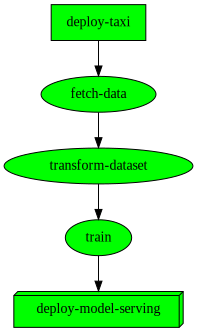

uid,start,state,name,parameters,results
...f69dd707,Aug 28 12:26:47,completed,train,,
...0563ca9b,Aug 28 12:25:01,completed,transform_dataset,,
...05f20edb,Aug 28 12:22:43,completed,fetch_data,,


In [39]:
artifact_path = path.abspath('./pipe/{{workflow.uid}}')
run_id = project.run(
    'main',    
    artifact_path=artifact_path, 
    dirty=True,
    watch=True)